# Using Non-linear Transformations

## Doing variable transformations

In [1]:
from sklearn.datasets import load_boston
import random
from random import shuffle

boston = load_boston()
random.seed(0) # Creates a replicable shuffling
new_index = list(range(boston.data.shape[0]))
shuffle(new_index) # shuffling the index
X, y = boston.data[new_index], boston.target[new_index]
print(X.shape, y.shape, boston.feature_names)

(506, 13) (506,) ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [2]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [3]:
import pandas as pd
df = pd.DataFrame(X,columns=boston.feature_names)
df['target'] = y

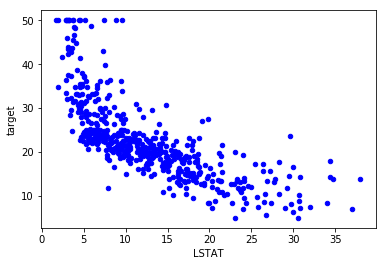

In [4]:
%matplotlib inline
ax = df.plot(kind='scatter', x='LSTAT', y='target', c='b')

In [5]:
import numpy as np
from sklearn.feature_selection import f_regression
single_variable = df['LSTAT'].values.reshape(-1, 1)
F, pval = f_regression(single_variable, y)
print('F score for the original feature %.1f' % F)
F, pval = f_regression(np.log(single_variable),y)
print('F score for the transformed feature %.1f' % F)

F score for the original feature 601.6
F score for the transformed feature 1000.2


## Creating interactions between variables

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection  import cross_val_score, KFold
regression = LinearRegression(normalize=True)
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

In [7]:
df = pd.DataFrame(X,columns=boston.feature_names)
baseline = np.mean(cross_val_score(regression, df, y, 
                                   scoring='r2', 
                                   cv=crossvalidation))
interactions = list()
for var_A in boston.feature_names:
    for var_B in boston.feature_names:
        if var_A > var_B:
            df['interaction'] = df[var_A] * df[var_B]
            cv = cross_val_score(regression, df, y, 
                                 scoring='r2', 
                                 cv=crossvalidation)
            score = round(np.mean(cv), 3)
            if score > baseline:
                interactions.append((var_A, var_B, score))
print('Baseline R2: %.3f' % baseline)
print('Top 10 interactions: %s' % sorted(interactions, 
                                    key=lambda x :x[2], 
                                    reverse=True)[:10])

Baseline R2: 0.716
Top 10 interactions: [('RM', 'LSTAT', 0.79), ('TAX', 'RM', 0.782), ('RM', 'RAD', 0.778), ('RM', 'PTRATIO', 0.766), ('RM', 'INDUS', 0.76), ('RM', 'NOX', 0.747), ('RM', 'AGE', 0.742), ('RM', 'B', 0.738), ('RM', 'DIS', 0.736), ('ZN', 'RM', 0.73)]


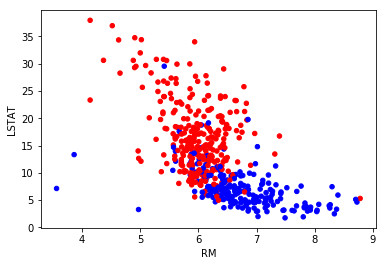

In [8]:
colors = ['b' if v > np.mean(y) else 'r' for v in y]
scatter = df.plot(kind='scatter', x='RM', y='LSTAT', 
                  c=colors)

In [9]:
# Adding polynomial features (x**2,y**2,xy)
polyX = pd.DataFrame(X,columns=boston.feature_names)
cv = cross_val_score(regression, polyX, y, 
                     scoring='neg_mean_squared_error', 
                     cv=crossvalidation)
baseline = np.mean(cv)
improvements = [baseline]
for var_A in boston.feature_names: 
    polyX[var_A+'^2'] = polyX[var_A]**2
    cv = cross_val_score(regression, polyX, y, 
                         scoring='neg_mean_squared_error', 
                         cv=crossvalidation)
    improvements.append(np.mean(cv))
    for var_B in boston.feature_names:
        if var_A > var_B:
            poly_var = var_A + '*' + var_B
            polyX[poly_var] = polyX[var_A] * polyX[var_B]
            cv = cross_val_score(regression, polyX, y, 
                         scoring='neg_mean_squared_error', 
                         cv=crossvalidation)
            improvements.append(np.mean(cv))

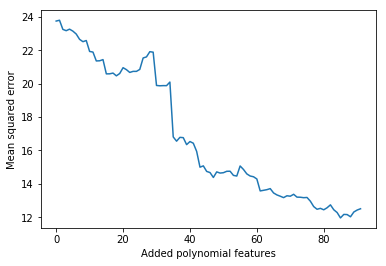

In [10]:
import matplotlib.pyplot as plt
plt.figure() 
plt.plot(range(0,92),np.abs(improvements),'-')
plt.xlabel('Added polynomial features')
plt.ylabel('Mean squared error')
plt.show()

In [11]:
print('New shape of X:', np.shape(polyX))
crossvalidation = KFold(n_splits=10, shuffle=True, 
                        random_state=1)
cv = cross_val_score(regression, polyX, y, 
                     scoring='neg_mean_squared_error', 
                     cv=crossvalidation)
print('Mean squared error: %.3f' % abs(np.mean(cv)))

New shape of X: (506, 104)
Mean squared error: 12.514


# Regularizing linear models

## Relying on ridge regression

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
ridge = Ridge(normalize=True)
search_grid = {'alpha':np.logspace(-5,2,8)}
search = GridSearchCV(estimator=ridge, 
                      param_grid=search_grid, 
                      scoring='neg_mean_squared_error', 
                      refit=True, cv=10)
search.fit(polyX,y)
print('Best parameters: %s' % search.best_params_)
score = abs(search.best_score_)
print('CV MSE of best parameters: %.3f' % score)

Best parameters: {'alpha': 0.001}
CV MSE of best parameters: 11.630


## Using the Lasso

In [13]:
from sklearn.linear_model import Lasso
lasso = Lasso(normalize=True,tol=0.05, selection='random')
search_grid = {'alpha':np.logspace(-5,3,8)}
search = GridSearchCV(estimator=lasso, 
                      param_grid=search_grid, 
                      scoring='neg_mean_squared_error', 
                      refit=True, cv=10)
search.fit(polyX,y)
print('Best parameters: %s' % search.best_params_)
score = abs(search.best_score_)
print('CV MSE of best parameters: %.3f' % score)

Best parameters: {'alpha': 1e-05}
CV MSE of best parameters: 12.472


## Leveraging regularization for feature selection

In [14]:
lasso = Lasso(normalize=True, alpha=0.01)
lasso.fit(polyX,y)
print(polyX.columns[np.abs(lasso.coef_)>0.0001].values)

['CRIM*CHAS' 'ZN*CRIM' 'ZN*CHAS' 'INDUS*DIS' 'CHAS*B' 'NOX^2' 'NOX*DIS'
 'RM^2' 'RM*CRIM' 'RM*NOX' 'RM*PTRATIO' 'RM*B' 'RM*LSTAT' 'RAD*B'
 'TAX*DIS' 'PTRATIO*NOX' 'LSTAT^2']


## Combining L1 & L2: Elasticnet

In [15]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(normalize=True, selection='random')
search_grid = {'alpha':np.logspace(-4,3,8), 
               'l1_ratio': [0.10 ,0.25, 0.5, 0.75]}
search = GridSearchCV(estimator=elastic, 
                      param_grid=search_grid, 
                      scoring='neg_mean_squared_error', 
                      refit=True, cv=10)
search.fit(polyX,y)
print('Best parameters: %s' % search.best_params_)
score = abs(search.best_score_)
print('CV MSE of best parameters: %.3f' % score)

Best parameters: {'alpha': 0.0001, 'l1_ratio': 0.75}
CV MSE of best parameters: 12.581


# Fighting with Big Data Chunk by Chunk

## Implementing Stochastic Gradient Descent

In [16]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

SGD = SGDRegressor(loss='squared_loss', 
                   penalty='l2', 
                   alpha=0.0001, 
                   l1_ratio=0.15, 
                   max_iter=2000,
                   random_state=1)
scaling = StandardScaler()
scaling.fit(polyX)
scaled_X = scaling.transform(polyX)
cv = cross_val_score(SGD, scaled_X, y, 
         scoring='neg_mean_squared_error', 
         cv=crossvalidation)
score = abs(np.mean(cv))
print('CV MSE: %.3f' % score)

CV MSE: 12.179


In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X_tr, X_t, y_tr, y_t = train_test_split(scaled_X, y, 
                                        test_size=0.20, 
                                        random_state=2)
SGD = SGDRegressor(loss='squared_loss', 
                   penalty='l2', 
                   alpha=0.0001, 
                   l1_ratio=0.15, 
                   max_iter=2000,
                   random_state=1)
improvements = list()
for z in range(10000):
    SGD.partial_fit(X_tr, y_tr)
    score = mean_squared_error(y_t, SGD.predict(X_t))
    improvements.append(score)

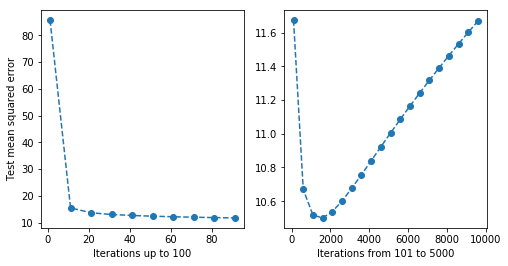

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
range_1 = range(1,101,10)
score_1 = np.abs(improvements[:100:10])
plt.plot(range_1, score_1,'o--')
plt.xlabel('Iterations up to 100')
plt.ylabel('Test mean squared error')
plt.subplot(1,2,2)
range_2 = range(100,10000,500)
score_2 = np.abs(improvements[100:10000:500])
plt.plot(range_2, score_2,'o--')
plt.xlabel('Iterations from 101 to 5000')
plt.show()

# Understanding Support Vector Machines

## Classifying with SVC

In [19]:
from sklearn import datasets
digits = datasets.load_digits()
X, y = digits.data, digits.target

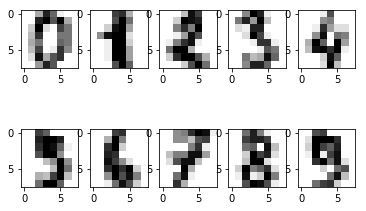

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

for k,img in enumerate(range(10)):
    plt.subplot(2, 5, k+1)
    plt.imshow(digits.images[img], 
               cmap='binary', 
               interpolation='none')
plt.show()

In [21]:
print(X[0])

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


In [22]:
print(X[0].reshape(8,8))

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


In [23]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180], dtype=int64))

In [24]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
X_tr, X_t, y_tr, y_t = train_test_split(X, y, 
                                        test_size=0.3, 
                                        random_state=0)

In [25]:
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(X_tr)
X_tr = scaling.transform(X_tr)
X_t = scaling.transform(X_t)

In [26]:
from sklearn.svm import SVC
svc = SVC(kernel='linear', 
          class_weight='balanced')

In [27]:
cv = cross_val_score(svc, X_tr, y_tr, cv=10)
test_score = svc.fit(X_tr, y_tr).score(X_t, y_t)

In [28]:
print('CV accuracy score: %0.3f' % np.mean(cv))
print('Test accuracy score: %0.3f' % (test_score))

CV accuracy score: 0.983
Test accuracy score: 0.976


In [29]:
from sklearn.model_selection  import GridSearchCV
svc = SVC(class_weight='balanced', random_state=1)
search_space = {'C': np.logspace(-3, 3, 7)}
gridsearch = GridSearchCV(svc, 
                          param_grid=search_space, 
                          scoring='accuracy', 
                          refit=True, cv=10)
gridsearch.fit(X_tr,y_tr)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [30]:
cv = gridsearch.best_score_
test_score = gridsearch.score(X_t, y_t)
best_c =  gridsearch.best_params_['C']

In [31]:
print('CV accuracy score: %0.3f' % cv)
print('Test accuracy score: %0.3f' % test_score)
print('Best C parameter: %0.1f' % best_c)

CV accuracy score: 0.989
Test accuracy score: 0.987
Best C parameter: 10.0


## Going nonlinear is easy

In [32]:
from sklearn.model_selection import GridSearchCV
svc = SVC(class_weight='balanced', random_state=1)
search_space = [{'kernel': ['linear'], 
                 'C': np.logspace(-3, 3, 7)},
                {'kernel': ['rbf'], 
                 'degree':[2, 3, 4], 
                 'C':np.logspace(-3, 3, 7), 
                 'gamma': np.logspace(-3, 2, 6)}]
gridsearch = GridSearchCV(svc, 
                          param_grid=search_space, 
                          scoring='accuracy', 
                          refit=True, cv=10,
                          n_jobs=-1)
gridsearch.fit(X_tr, y_tr)
cv = gridsearch.best_score_
test_score = gridsearch.score(X_t, y_t)
print('CV accuracy score: %0.3f' % cv)
print('Test accuracy score: %0.3f' % test_score)
print('Best parameters: %s' % gridsearch.best_params_)

CV accuracy score: 0.990
Test accuracy score: 0.993
Best parameters: {'C': 1.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}


## Performing regression with SVR

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn import datasets

boston = datasets.load_boston()
X,y = boston.data, boston.target
X_tr, X_t, y_tr, y_t = train_test_split(X, y, 
                                        test_size=0.3, 
                                        random_state=0)
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(X_tr)
X_tr = scaling.transform(X_tr)
X_t  = scaling.transform(X_t)

In [34]:
svr = SVR()
search_space = [{'kernel': ['linear'], 
                 'C': np.logspace(-3, 2, 6), 
                 'epsilon': [0, 0.01, 0.1, 0.5, 1, 2, 4]},
                {'kernel': ['rbf'], 
                 'degree':[2,3], 
                 'C':np.logspace(-3, 3, 7), 
                 'gamma': np.logspace(-3, 2, 6), 
                 'epsilon': [0, 0.01, 0.1, 0.5, 1, 2, 4]}]
gridsearch = GridSearchCV(svr, 
                          param_grid=search_space, 
                          refit=True, 
                          scoring= 'r2',
                          cv=10, n_jobs=-1)
gridsearch.fit(X_tr, y_tr)
cv = gridsearch.best_score_
test_score = gridsearch.score(X_t, y_t)
print('CV R2 score: %0.3f' % cv)
print('Test R2 score: %0.3f' % test_score)
print('Best parameters: %s' % gridsearch.best_params_)

CV R2 score: 0.868
Test R2 score: 0.834
Best parameters: {'C': 1000.0, 'degree': 2, 'epsilon': 2, 'gamma': 0.1, 'kernel': 'rbf'}


## Creating a stochastic solution with SVM

In [35]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
X,y = make_classification(n_samples=10**4, 
                          n_features=15, 
                          n_informative=10, 
                          random_state=101)
X_tr, X_t, y_tr, y_t = train_test_split(X, y, 
                                        test_size=0.3, 
                                        random_state=1)

from sklearn.svm import SVC, LinearSVC
svc = SVC(kernel='linear', random_state=1)
linear = LinearSVC(loss='hinge', random_state=1)

svc.fit(X_tr, y_tr)
linear.fit(X_tr, y_tr)
svc_score = svc.score(X_t, y_t)
libsvc_score = linear.score(X_t, y_t)
print('SVC test accuracy: %0.3f' % svc_score)
print('LinearSVC test accuracy: %0.3f' % libsvc_score)

SVC test accuracy: 0.803
LinearSVC test accuracy: 0.804


In [36]:
import timeit
X,y = make_classification(n_samples=10**4, 
                          n_features=15, 
                          n_informative=10, 
                          random_state=101)
t_svc = timeit.timeit('svc.fit(X, y)',
                      'from __main__ import svc, X, y', 
                      number=1)
t_libsvc = timeit.timeit('linear.fit(X, y)',
                         'from __main__ import linear, X, y', 
                         number=1)
print('best avg secs for SVC: %0.1f' % np.mean(t_svc))
print('best avg secs for LinearSVC: %0.1f' % np.mean(t_libsvc))

best avg secs for SVC: 21.7
best avg secs for LinearSVC: 0.6


In [37]:
import timeit
X,y = make_classification(n_samples=3*10**4, 
                          n_features=15, 
                          n_informative=10, 
                          random_state=101)
t_svc = timeit.timeit('svc.fit(X, y)',
                      'from __main__ import svc, X, y', 
                      number=1)
t_linear = timeit.timeit('linear.fit(X, y)',
                         'from __main__ import linear, X, y', 
                         number=1)
print('Avg time for SVC: %0.1f secs' % np.mean(t_svc))
print('Avg time for LinearSVC: %0.1f secs' % np.mean(t_linear))

Avg time for SVC: 211.9 secs
Avg time for LinearSVC: 3.1 secs


In [38]:
import timeit
X,y = make_classification(n_samples=5*10**4, 
                          n_features=15, 
                          n_informative=10, 
                          random_state=101)
t_svc = timeit.timeit('svc.fit(X, y)',
                      'from __main__ import svc, X, y', 
                      number=1)
t_linear = timeit.timeit('linear.fit(X, y)',
                         'from __main__ import linear, X, y', 
                         number=1)
print('Avg time for SVC: %0.1f secs' % np.mean(t_svc))
print('Avg time for LinearSVC: %0.1f secs' % np.mean(t_linear))

Avg time for SVC: 640.0 secs
Avg time for LinearSVC: 4.9 secs


In [39]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
import timeit

from sklearn.linear_model import SGDClassifier
X, y = make_classification(n_samples=10**5, 
                           n_features=15, 
                           n_informative=10, 
                           random_state=101)
X_tr, X_t, y_tr, y_t = train_test_split(X, y,
                                        test_size=0.3, 
                                        random_state=1)

In [40]:
linear = LinearSVC(penalty='l2', 
                   loss='hinge', 
                   dual=True,
                   random_state=1)
linear.fit(X_tr, y_tr)
score = linear.score(X_t, y_t)
t = timeit.timeit("linear.fit(X_tr, y_tr)", 
        "from __main__ import linear, X_tr, y_tr", 
        number=1)
print('LinearSVC test accuracy: %0.3f' % score)
print('Avg time for LinearSVC: %0.1f secs' % np.mean(t))

LinearSVC test accuracy: 0.796
Avg time for LinearSVC: 8.8 secs


In [41]:
sgd = SGDClassifier(loss='hinge',
                    max_iter=100, 
                    shuffle=True, 
                    random_state=101)
sgd.fit(X_tr, y_tr)
score = sgd.score(X_t, y_t)
t = timeit.timeit("sgd.fit(X_tr, y_tr)", 
                  "from __main__ import sgd, X_tr, y_tr", 
                  number=1)
print('SGDClassifier test accuracy: %0.3f' % score)
print('Avg time for SGDClassifier: %0.1f secs' % np.mean(t))

SGDClassifier test accuracy: 0.796
Avg time for SGDClassifier: 1.7 secs


# Playing with Neural Networks

In [42]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn.neural_network import MLPClassifier

In [43]:
digits = datasets.load_digits()
X, y = digits.data, digits.target
X_tr, X_t, y_tr, y_t = train_test_split(X, y, 
                                        test_size=0.3, 
                                        random_state=0)
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(X_tr)
X_tr = scaling.transform(X_tr)
X_t = scaling.transform(X_t)

In [44]:
nn = MLPClassifier(hidden_layer_sizes=(512, ), 
                   activation='relu', 
                   solver='adam',
                   shuffle=True,
                   tol=1e-4,
                   random_state=1)

In [45]:
cv = cross_val_score(nn, X_tr, y_tr, cv=10)
test_score = nn.fit(X_tr, y_tr).score(X_t, y_t)
print('CV accuracy score: %0.3f' % np.mean(cv))
print('Test accuracy score: %0.3f' % (test_score))

CV accuracy score: 0.978
Test accuracy score: 0.981
